Model: Predicting traffic accident severity with structured data -

In this notebook we will be using Machine Learning models in order to predict traffic accident severity. The data is a combination of accident, population, and traffic data collected in the UK from 2013-2017. For this model we will be focusing on just accidents in London and before modeling, we will further check and clean the data.

In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 50)
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(123)
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import sys
!{sys.executable} -m pip install xgboost
from xgboost import XGBClassifier, plot_importance, plot_tree
import itertools

In [3]:
accidents = pd.read_csv('Data/01. Accidents/London_accidents_merged.csv')

In [4]:
accidents.head()

,Unnamed: 0,Accident_Index,Longitude,Latitude,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,1st_Road_Class,Road_Type,Speed_limit,Junction_Detail,2nd_Road_Class,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Urban_or_Rural_Area,Hour,Two_Hour_Groupings,Time_of_Day,Was_Daylight,Was_Bad_Weather,Was_Road_Dry,log_Number_of_Casualties,log_Number_of_Vehicles,LSOA,population_per_hectare,bicycle_aadf,motorbike_aadf,car_aadf,bus_aadf,light_goods_vehicle_aadf,heavy_goods_vehicle_aadf
0,0,201301BS70003,-0.171402,51.486361,Serious,2,1,2013-01-02,Wednesday,A,Single carriageway,30,T or staggered junction,Unclassified,Daylight,Fine no high winds,Dry,Urban,9,8am-10am,Morning,Yes,No,Yes,0.000000,0.693147,E01002844,110.8,1634.4,860.4,14888.0,1139.8,2297.0,352.0
1,1,201301BS70005,-0.173356,51.495115,Slight,1,2,2013-01-04,Friday,A,Single carriageway,30,Crossroads,A,Daylight,Other,Dry,Urban,8,8am-10am,Morning,Yes,Yes,Yes,0.693147,0.000000,E01002821,74.6,559.6,1516.0,28505.6,1396.2,3868.6,1003.0
2,2,201301BS70006,-0.210767,51.518353,Slight,1,1,2013-01-07,Monday,B,Single carriageway,30,Crossroads,B,Daylight,Fine no high winds,Dry,Urban,11,10am-12pm,Office hours,Yes,No,Yes,0.000000,0.000000,E01002878,133.4,2.6,3898.2,63274.8,763.4,15253.6,3185.8
3,3,201301BS70007,-0.209675,51.516808,Slight,2,1,2013-01-10,Thursday,B,Single carriageway,30,Crossroads,C,Daylight,Fine no high winds,Dry,Urban,10,10am-12pm,Office hours,Yes,No,Yes,0.000000,0.693147,E01002831,179.2,2.6,3898.2,63274.8,763.4,15253.6,3185.8
4,4,201301BS70009,-0.194332,51.492922,Slight,2,1,2013-01-04,Friday,A,One way street,30,T or staggered junction,Unclassified,Darkness - lights lit,Fine no high winds,Dry,Urban,17,4pm-6pm,Rush hour,No,No,Yes,0.000000,0.693147,E01002851,272.3,869.2,1229.8,20478.6,897.2,4951.6,1251.4


In [5]:
accidents['Month'] = pd.to_datetime(accidents['Date']).dt.month_name()

In [7]:
accidents.drop(['Accident_Index', 'Longitude', 'Latitude', 'Number_of_Vehicles', 'Number_of_Casualties', 
                'Date', 'Light_Conditions', 'Weather_Conditions', 'Road_Surface_Conditions', 'Hour', 
                'Time_of_Day', 'log_Number_of_Casualties', 'log_Number_of_Vehicles', 'LSOA'], 
               axis=1, inplace=True)

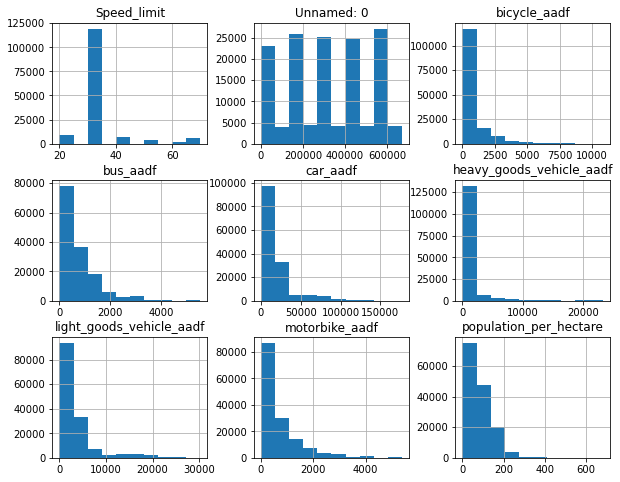

In [8]:
accidents.hist(figsize=(10,8));

In [9]:
to_log_transform = list(accidents.columns[accidents.columns.str.endswith('aadf') == True])
to_log_transform.append('population_per_hectare')

# Replacing 0s with 0.1s to allow for log transformation
accidents[to_log_transform] = accidents[to_log_transform].replace(0, 0.1)

# Adding log transformed columns and dropping original columns
for col in to_log_transform:
    log_col = "log_"+col
    accidents[log_col] = np.log(accidents[col])
    accidents.drop(col, axis=1, inplace=True)

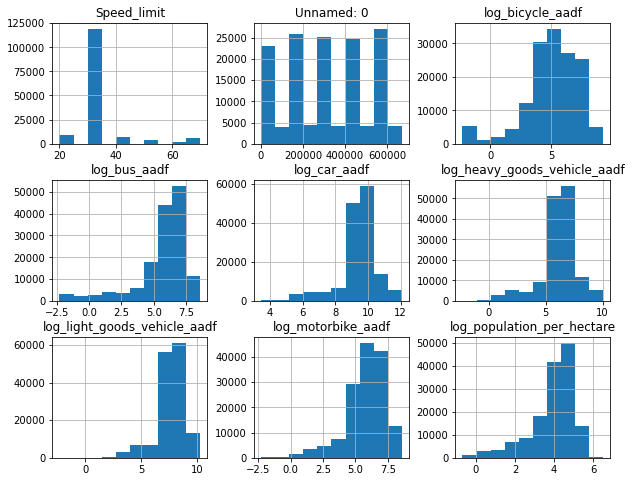

In [10]:
accidents.hist(figsize=(10,8));

In [11]:
accidents['Accident_Severity'].replace({'Slight': 1, 'Serious': 2, 'Fatal': 3}, inplace=True)
accidents['Accident_Severity'] = accidents['Accident_Severity'].astype('int64')

In [12]:
transformed_df = pd.get_dummies(accidents, drop_first=True)

In [13]:
def multi_collinearity_heatmap(df, figsize=(11,9), annot=False):
    
    """
    Creates a heatmap of correlations between features in the df. A figure size can optionally be set.
    """
    
    # Set the style of the visualization
    sns.set(style="white")

    # Create a covariance matrix
    corr = df.corr()

    # Generate a mask the size of our covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, annot=annot, cbar_kws={"shrink": .5}, vmax=corr[corr != 1.0].max().max());

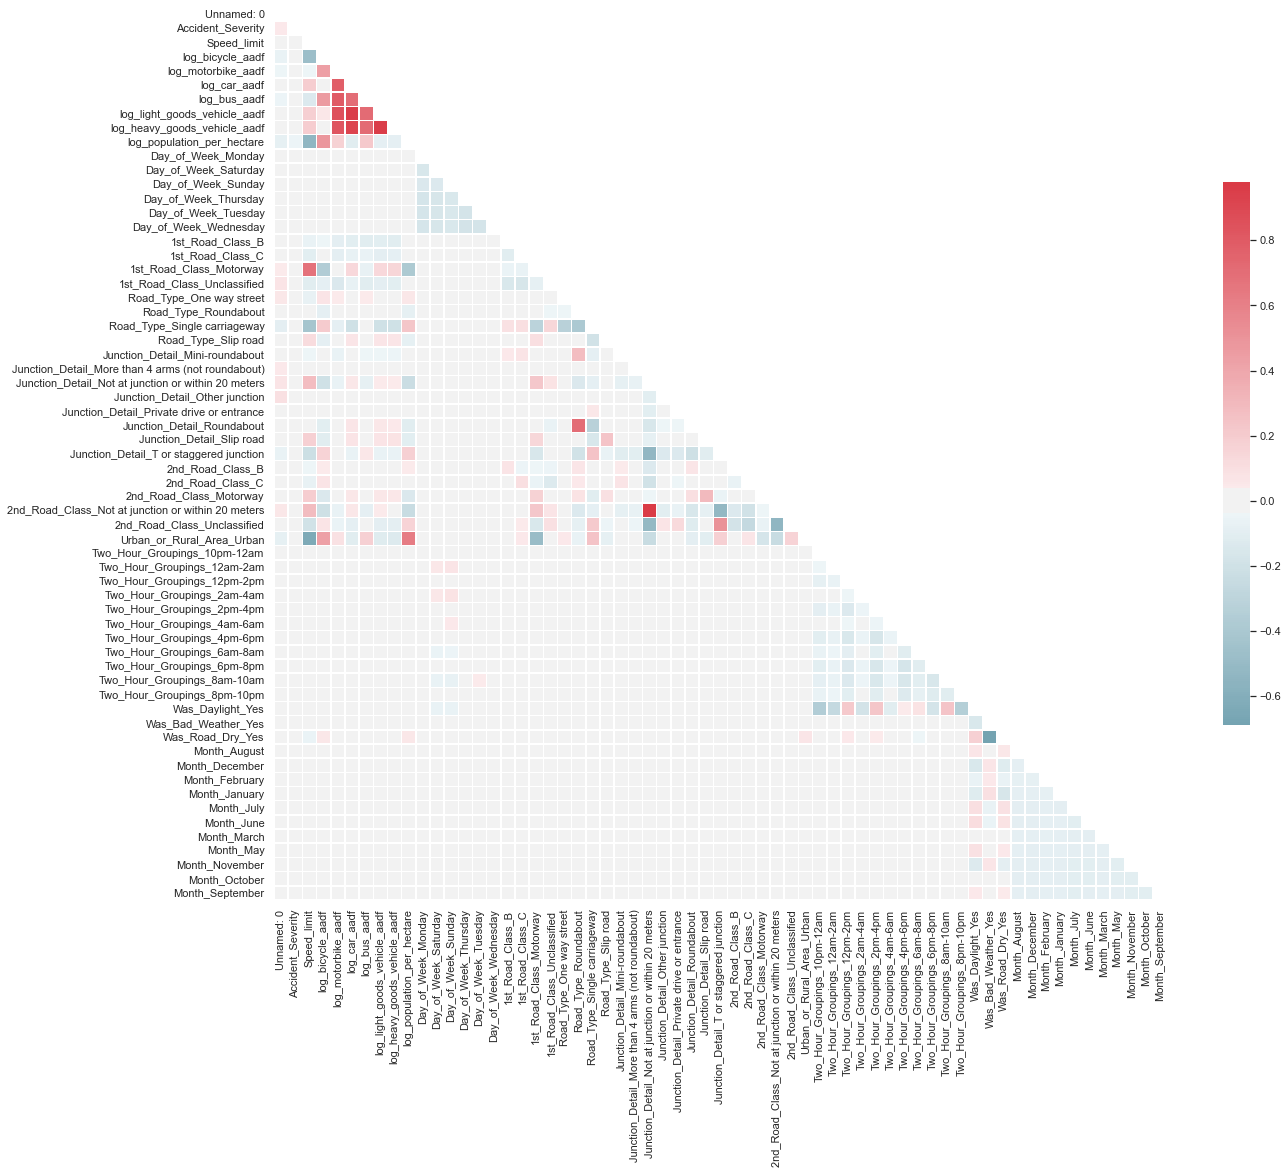

In [14]:
multi_collinearity_heatmap(transformed_df, figsize=(20,20))

In [19]:
transformed_df['log_motor_vehicle_aadf'] = np.log(np.exp(transformed_df['log_motorbike_aadf'])
    + np.exp(transformed_df['log_car_aadf'])
    + np.exp(transformed_df['log_bus_aadf'])
    + np.exp(transformed_df['log_light_goods_vehicle_aadf'])
    + np.exp(transformed_df['log_heavy_goods_vehicle_aadf']))

In [20]:
transformed_df.drop(['log_motorbike_aadf', 'log_car_aadf', 'log_bus_aadf', 'log_light_goods_vehicle_aadf', 'log_heavy_goods_vehicle_aadf'], axis=1, inplace=True)

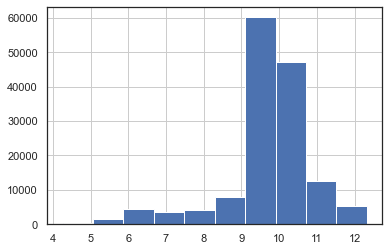

In [21]:
transformed_df.log_motor_vehicle_aadf.hist();

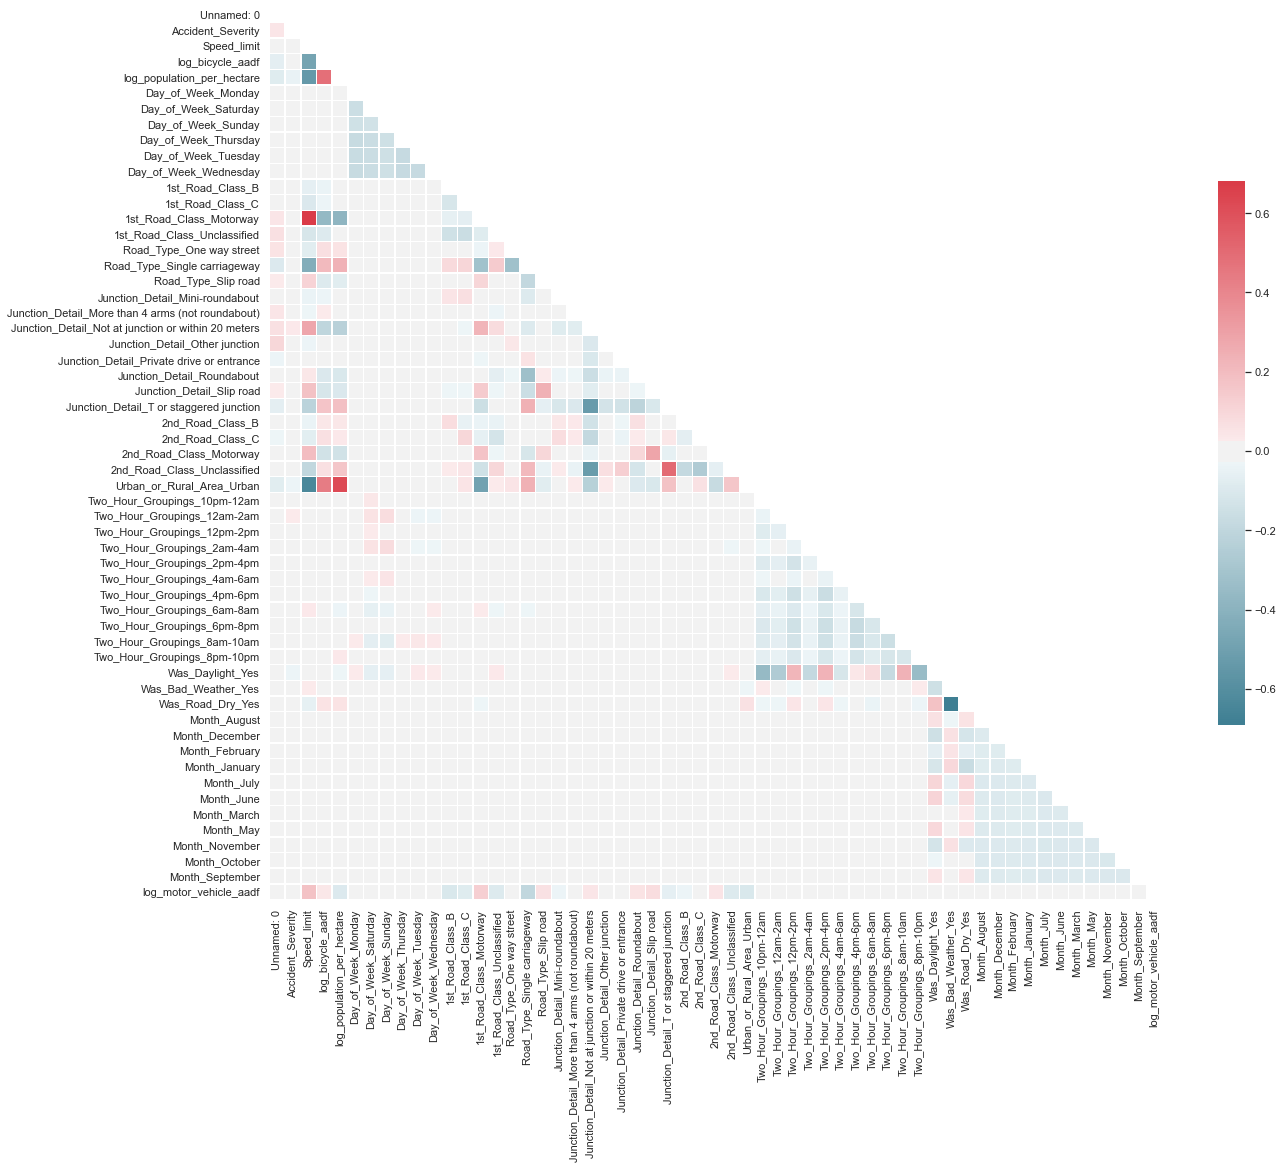

In [22]:
multi_collinearity_heatmap(transformed_df, figsize=(20,20))

Split and Scale Data for Modeling -

In [23]:
transformed_df.Accident_Severity.value_counts(normalize=True)

1    0.894322
2    0.100171
3    0.005507
Name: Accident_Severity, dtype: float64

In [24]:
X = transformed_df.drop('Accident_Severity', axis=1)
y = transformed_df['Accident_Severity']
y = y.replace([2,3], [0,0])

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

In [26]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=list(X_train.columns))
X_test = pd.DataFrame(scaler.transform(X_test), columns=list(X_test.columns))
X_train.head()

,Unnamed: 0,Speed_limit,log_bicycle_aadf,log_population_per_hectare,Day_of_Week_Monday,Day_of_Week_Saturday,Day_of_Week_Sunday,Day_of_Week_Thursday,Day_of_Week_Tuesday,Day_of_Week_Wednesday,1st_Road_Class_B,1st_Road_Class_C,1st_Road_Class_Motorway,1st_Road_Class_Unclassified,Road_Type_One way street,Road_Type_Single carriageway,Road_Type_Slip road,Junction_Detail_Mini-roundabout,Junction_Detail_More than 4 arms (not roundabout),Junction_Detail_Not at junction or within 20 meters,Junction_Detail_Other junction,Junction_Detail_Private drive or entrance,Junction_Detail_Roundabout,Junction_Detail_Slip road,Junction_Detail_T or staggered junction,...,Two_Hour_Groupings_12am-2am,Two_Hour_Groupings_12pm-2pm,Two_Hour_Groupings_2am-4am,Two_Hour_Groupings_2pm-4pm,Two_Hour_Groupings_4am-6am,Two_Hour_Groupings_4pm-6pm,Two_Hour_Groupings_6am-8am,Two_Hour_Groupings_6pm-8pm,Two_Hour_Groupings_8am-10am,Two_Hour_Groupings_8pm-10pm,Was_Daylight_Yes,Was_Bad_Weather_Yes,Was_Road_Dry_Yes,Month_August,Month_December,Month_February,Month_January,Month_July,Month_June,Month_March,Month_May,Month_November,Month_October,Month_September,log_motor_vehicle_aadf
0,-0.826424,-0.244613,-0.996386,-0.061492,2.469861,-0.387282,-0.346434,-0.426525,-0.42157,-0.427059,-0.314826,-0.359186,-0.181469,2.195634,-0.185062,0.579262,-0.10971,-0.1311,-0.118789,1.585570,-0.158095,-0.161938,-0.253174,-0.125777,-0.837753,...,-0.171193,-0.346598,-0.127035,-0.379662,-0.123072,-0.427504,-0.270703,-0.405821,2.651854,-0.290828,0.654190,-0.382906,0.488269,-0.292621,-0.296908,-0.275646,-0.291213,3.141940,-0.307819,-0.294606,-0.304720,-0.321271,-0.319207,-0.304045,-2.464314
1,-0.843451,-0.244613,1.092049,1.115207,-0.404881,-0.387282,2.886556,-0.426525,-0.42157,-0.427059,-0.314826,-0.359186,-0.181469,-0.455449,-0.185062,0.579262,-0.10971,-0.1311,-0.118789,-0.630688,-0.158095,-0.161938,-0.253174,-0.125777,1.193670,...,-0.171193,-0.346598,-0.127035,-0.379662,-0.123072,-0.427504,-0.270703,-0.405821,-0.377095,3.438454,-1.528607,-0.382906,0.488269,-0.292621,-0.296908,-0.275646,-0.291213,-0.318275,-0.307819,-0.294606,3.281699,-0.321271,-0.319207,-0.304045,0.355863
2,1.239036,-0.244613,1.112161,0.782311,-0.404881,-0.387282,2.886556,-0.426525,-0.42157,-0.427059,-0.314826,2.784075,-0.181469,-0.455449,-0.185062,0.579262,-0.10971,-0.1311,-0.118789,-0.630688,-0.158095,-0.161938,-0.253174,-0.125777,-0.837753,...,-0.171193,-0.346598,-0.127035,-0.379662,-0.123072,-0.427504,-0.270703,2.464141,-0.377095,-0.290828,-1.528607,-0.382906,-2.048052,-0.292621,-0.296908,-0.275646,3.433911,-0.318275,-0.307819,-0.294606,-0.304720,-0.321271,-0.319207,-0.304045,-0.112248
3,-0.024499,-0.244613,0.504993,0.818145,-0.404881,-0.387282,-0.346434,-0.426525,-0.42157,2.341597,-0.314826,-0.359186,-0.181469,2.195634,-0.185062,0.579262,-0.10971,-0.1311,-0.118789,-0.630688,-0.158095,-0.161938,-0.253174,-0.125777,1.193670,...,-0.171193,2.885189,-0.127035,-0.379662,-0.123072,-0.427504,-0.270703,-0.405821,-0.377095,-0.290828,0.654190,-0.382906,0.488269,-0.292621,-0.296908,-0.275646,-0.291213,-0.318275,-0.307819,-0.294606,-0.304720,-0.321271,-0.319207,3.288991,0.325945
4,0.660777,-0.244613,0.165828,-0.129147,-0.404881,-0.387282,-0.346434,-0.426525,-0.42157,2.341597,-0.314826,-0.359186,-0.181469,-0.455449,-0.185062,-1.726334,-0.10971,-0.1311,-0.118789,-0.630688,-0.158095,-0.161938,-0.253174,-0.125777,1.193670,...,-0.171193,-0.346598,-0.127035,-0.379662,-0.123072,-0.427504,-0.270703,-0.405821,2.651854,-0.290828,0.654190,-0.382906,0.488269,3.417388,-0.296908,-0.275646,-0.291213,-0.318275,-0.307819,-0.294606,-0.304720,-0.321271,-0.319207,-0.304045,0.195404


Modelling: Logistic Regression -

In [27]:
lr = LogisticRegression(solver='liblinear', random_state=42)
lr.fit(X_train, y_train)

LogisticRegression(random_state=42, solver='liblinear')

In [28]:
print("Train:", lr.score(X_train, y_train))
print("Test:", lr.score(X_test, y_test))

lr_y_preds_train = lr.predict(X_train)
print(classification_report(y_train, lr_y_preds_train, target_names=['major', 'minor']))

lr_y_preds_test = lr.predict(X_test)
print(classification_report(y_test, lr_y_preds_test, target_names=['major', 'minor']))

Train: 0.8941132745929874
Test: 0.8949500992576075
              precision    recall  f1-score   support

       major       0.00      0.00      0.00     11681
       minor       0.89      1.00      0.94     98635

    accuracy                           0.89    110316
   macro avg       0.45      0.50      0.47    110316
weighted avg       0.80      0.89      0.84    110316

              precision    recall  f1-score   support

       major       0.00      0.00      0.00      3863
       minor       0.89      1.00      0.94     32910

    accuracy                           0.89     36773
   macro avg       0.45      0.50      0.47     36773
weighted avg       0.80      0.89      0.85     36773



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
def plot_cf(y_true, y_pred, class_names=None, model_name=None):
    """Plots a confusion matrix"""
    cf = confusion_matrix(y_true, y_pred)
    plt.imshow(cf, cmap=plt.cm.Blues)
    if model_name:
        plt.title("Confusion Matrix: {}".format(model_name))
    else:
        plt.title("Confusion Matrix")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    #class_names = set(y_true)
    tick_marks = np.arange(len(class_names))
    if class_names:
        plt.xticks(tick_marks, class_names)
        plt.yticks(tick_marks, class_names)
    
    thresh = cf.max() / 2.
    
    for i, j in itertools.product(range(cf.shape[0]), range(cf.shape[1])):
        plt.text(j, i, cf[i, j], horizontalalignment='center', color='white' if cf[i, j] > thresh else 'black')

    plt.colorbar()

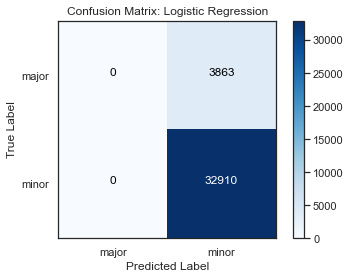

In [30]:
plot_cf(y_test, lr_y_preds_test, model_name='Logistic Regression', class_names=['major', 'minor'])

Conclusion -

This isn't a 100% reliable model to consider for traffic accidents but it can provide a certain sense of information, other models, such as (XGBoost based and downsampling model) can be made to predict the data more accurately.
This can be left for future work.